In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder
from gensim.models import Word2Vec
from torch.autograd import Variable

import string
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
#from spellchecker import SpellChecker
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wangd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wangd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('../Lab2/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
def preprocess_text(column):
    # Convert to string and lowercase
    column = column.astype(str).str.lower()

    # Remove punctuation
    column = column.apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    column = column.apply(lambda text: " ".join([word for word in text.split() if word not in stop_words]))

    # Count word frequencies
    cnt = Counter()
    for text in column:
        for word in text.split():
            cnt[word] += 1

    # Remove common words
    common_words = set([w for (w, wc) in cnt.most_common(10)])
    column = column.apply(lambda text: " ".join([word for word in text.split() if word not in common_words]))

    # Remove rare words
    rare_words = set([w for (w, wc) in cnt.most_common()[:-11:-1]])
    column = column.apply(lambda text: " ".join([word for word in text.split() if word not in rare_words]))

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    column = column.apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

    # Remove emojis
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    column = column.apply(remove_emoji)

    # Remove URLs
    def remove_urls(text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub(r'', text)

    column = column.apply(remove_urls)

    # Remove HTML tags
    column = column.apply(lambda text: BeautifulSoup(text, "lxml").text)

    # Correct spelling
    # spell = SpellChecker()
    # def correct_spellings(text):
    #     corrected_text = []
    #     misspelled_words = spell.unknown(text.split())
    #     for word in text.split():
    #         if word in misspelled_words:
    #             corrected_text.append(spell.correction(word))
    #         else:
    #             corrected_text.append(word)
    #     return " ".join(corrected_text)

    # column = column.apply(correct_spellings)

    return column

# Example usage:
df['review'] = preprocess_text(df['review'])


In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
df

,review,sentiment
0,reviewer mentioned watching 1 oz episode youll...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend hot summer weekend...,1
3,basically there family little boy jake think t...,0
4,petter matteis love money visually stunning wa...,1
...,...,...
49995,thought right job wasnt creative original firs...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,im going disagree previous comment side maltin...,0


In [6]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [14]:
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=100, max_vectors=400000)

100%|█████████▉| 399999/400000 [00:21<00:00, 18204.77it/s]


In [15]:
def get_review_words(df, glove_vector):
    train, valid, test = [], [], []
    for i, row in df.iterrows():
        review = row['review']
        sentiment = row['sentiment']
        
        # Get indices of words that have embeddings
        idxs = [glove_vector.stoi[w]
                for w in review.split()
                if w in glove_vector.stoi]

        # Ignore reviews without any word with an embedding
        if not idxs:
            continue
        
        # Convert list to PyTorch tensor
        idxs = torch.tensor(idxs)
        label = torch.tensor(int(sentiment)).long()

        # Split data into train, validation, and test
        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    
    return train, valid, test

# Assuming your DataFrame is named `df`
train, valid, test = get_review_words(df, glove)

# Print the first review and label
review, label = train[0]
print(review)
print(label) 

tensor([ 15644,   3042,   2641,    176,  12961,   1942, 363010,  12765,    248,
          2796,   1579,     58,    873,   1869,  12961,  13155,  45655,   1500,
           714,    208,    248,   1388,    242,   1853,    273,  17173,  21360,
         25440,    273,   2933,   7849,   4641,    780,   1739,    714,  16357,
          2392,    234,    175,  12961,   7398,    454,  17864,   2964,    194,
            92,   1254,   1674,  19720,    115,   6122,   1519,    997,   2114,
          2847,    669,    621,  67371,   5310,    152,   2804,  23608,    115,
           163,   1172,  33334,   5894,   1377,   1031,   1838, 150928,  24331,
           336,  18917,  59473,   3437,  18395,    547,    332,    372,    203,
           444,   1574,    273,    445,    853,    242,    273, 255441,  12248,
          4458,   1922,   1835,   4605,   4826,   2052,   4458,   9916,   4458,
        136283,   7562,    204,     58,   1942,    661,    822,   1869,  10764,
         17659, 199092,    203,   1188, 

In [16]:
for i in range(10):
    review, label = train[i]
    print(review.shape)

torch.Size([157])
torch.Size([79])
torch.Size([80])
torch.Size([52])
torch.Size([58])
torch.Size([77])
torch.Size([42])
torch.Size([79])
torch.Size([196])
torch.Size([63])


In [17]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

# Example: we use the forward function of glove_emb to lookup the
# embedding of each word in `review`
review_emb = glove_emb(review)
review_emb.shape

torch.Size([63, 100])

In [22]:
rnn_layer= nn.RNN(input_size=100,hidden_size=100, batch_first=True)

review_input= review_emb.unsqueeze(0) #add batch size dim
h0 = torch.zeros(1, 1, 100) #initial hidden state
out, last_hidden = rnn_layer(review_input, h0)
out.shape, last_hidden.shape

(torch.Size([1, 63, 100]), torch.Size([1, 1, 100]))

In [23]:
out2, last_hidden2 = rnn_layer(review_input)

Building model

In [24]:
class reviewRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(reviewRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x,h0)
        out = self.fc(out[:, -1, :])
        return out
model= reviewRNN(100, 100, 2)

In [25]:
#not using Dataloder with a batch_size of greater than one as each review has a different shaped tensor
#pytorch Data loader class expects all data samples to have the same shape 
#so we will need a different way of batching
#we will use the pad_sequence function to pad the reviews to the same length

In [28]:
from torch.nn.utils.rnn import pad_sequence

review_padded=pad_sequence([review for review, label in train[:10]], batch_first=True)
review_padded.shape

torch.Size([10, 196])

In [29]:
out= model(review_padded)
out.shape

torch.Size([10, 2])

In [30]:
#usually we take last output unit as input to the final classifier now that we have padded the input sequences we should use output at a previous time step
#The longest tweet has many more words than the shortest, padding tweets so that every tweet has the same length as the longest tweet is impractical, padding tweets in a mini batch however is more reasonable
#In practice tweets with same length are Batched together but there are flaws

In [31]:
import random

class ReviewBatcther:
    def __init__(self, reviews, batch_size=32, drop_last=False):
        self.reviews_by_length = {}
        for words, label in reviews:
            wlen = words.shape[0]
            if wlen not in self.reviews_by_length:
                self.reviews_by_length[wlen] = []
            self.reviews_by_length[wlen].append((words, label),)

        self.loaders = {wlen : torch.utils.data.DataLoader(reviews, batch_size=batch_size, shuffle=True, drop_last=drop_last)
                        for wlen, reviews in self.reviews_by_length.items()}
        
    def __iter__(self):
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

In [32]:
for i, (reviews, labels) in enumerate(ReviewBatcther(train, drop_last=True)):
    if i>5: break
    print(reviews.shape,labels.shape)

torch.Size([32, 201]) torch.Size([32])
torch.Size([32, 50]) torch.Size([32])
torch.Size([32, 43]) torch.Size([32])
torch.Size([32, 38]) torch.Size([32])
torch.Size([32, 57]) torch.Size([32])
torch.Size([32, 67]) torch.Size([32])


In [33]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for reviews, labels in data_loader:
        output = model(reviews)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

test_loader = ReviewBatcther(test, batch_size=64, drop_last=False)
get_accuracy(model, test_loader)

0.4988

In [34]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for reviews, labels in train:
            optimizer.zero_grad()
            pred = model(reviews)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.690150; Train Acc 0.531696; Val Acc 0.521900
Epoch 2; Loss 0.677823; Train Acc 0.561359; Val Acc 0.553300
Epoch 3; Loss 0.646176; Train Acc 0.585119; Val Acc 0.573700
Epoch 4; Loss 0.676983; Train Acc 0.605903; Val Acc 0.592300
Epoch 5; Loss 0.674483; Train Acc 0.624306; Val Acc 0.609200
Epoch 6; Loss 0.613191; Train Acc 0.647024; Val Acc 0.628800
Epoch 7; Loss 0.612181; Train Acc 0.679266; Val Acc 0.667600
Epoch 8; Loss 0.559698; Train Acc 0.745685; Val Acc 0.736800
Epoch 9; Loss 0.524830; Train Acc 0.754960; Val Acc 0.744000
Epoch 10; Loss 0.543617; Train Acc 0.760466; Val Acc 0.748800
Epoch 11; Loss 0.472265; Train Acc 0.764435; Val Acc 0.751800
Epoch 12; Loss 0.481200; Train Acc 0.767708; Val Acc 0.754300
Epoch 13; Loss 0.506641; Train Acc 0.769246; Val Acc 0.755300
Epoch 14; Loss 0.451113; Train Acc 0.771677; Val Acc 0.755100
Epoch 15; Loss 0.384048; Train Acc 0.773313; Val Acc 0.756500
Epoch 16; Loss 0.527374; Train Acc 0.776885; Val Acc 0.758500
Epoch 17; Loss 0.

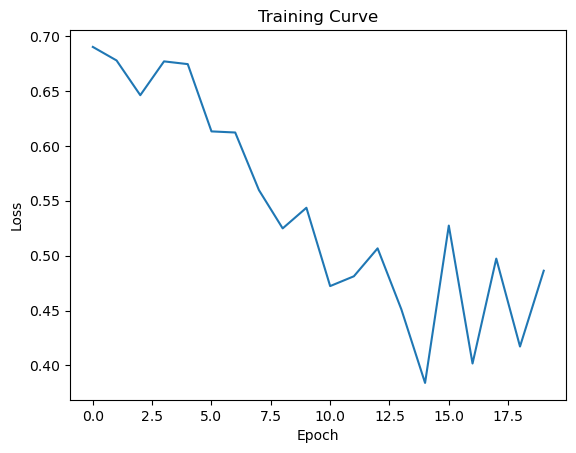

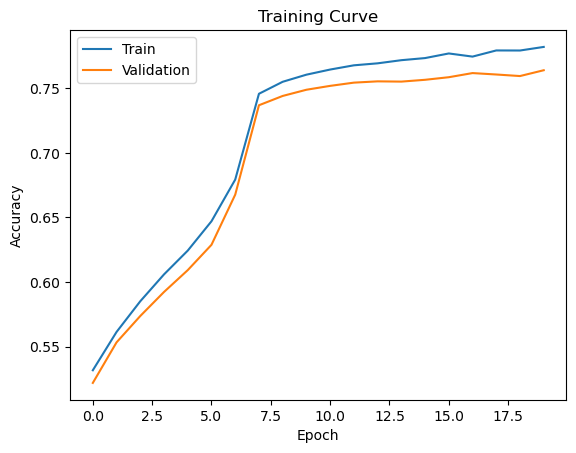

0.7705

In [36]:
model= reviewRNN(100, 100, 2)
train_loader = ReviewBatcther(train, batch_size=64, drop_last=True)
valid_loader = ReviewBatcther(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-5)
get_accuracy(model, test_loader)

## LSTM

In [37]:
lstm_layer = nn.LSTM(input_size=100,   
                    hidden_size=100,
                    batch_first=True)

review_input = review_emb.unsqueeze(0) # add batch size dimension
h0 = torch.zeros(1, 1, 100) # initial hidden state
c0 = torch.zeros(1, 1, 100) # initial cell state
out, last_hidden = lstm_layer(review_input, (h0, c0))
out.shape, last_hidden[0].shape, last_hidden[1].shape

(torch.Size([1, 63, 100]), torch.Size([1, 1, 100]), torch.Size([1, 1, 100]))

Epoch 1; Loss 0.534369; Train Acc 0.783532; Val Acc 0.766500
Epoch 2; Loss 0.512332; Train Acc 0.786954; Val Acc 0.765900
Epoch 3; Loss 0.468125; Train Acc 0.790575; Val Acc 0.767000
Epoch 4; Loss 0.368637; Train Acc 0.787351; Val Acc 0.769400
Epoch 5; Loss 0.458966; Train Acc 0.788145; Val Acc 0.772000
Epoch 6; Loss 0.462669; Train Acc 0.789782; Val Acc 0.774700
Epoch 7; Loss 0.425210; Train Acc 0.794048; Val Acc 0.773100
Epoch 8; Loss 0.486304; Train Acc 0.792411; Val Acc 0.773000
Epoch 9; Loss 0.451245; Train Acc 0.795685; Val Acc 0.775400
Epoch 10; Loss 0.646642; Train Acc 0.794296; Val Acc 0.775500
Epoch 11; Loss 0.449652; Train Acc 0.797669; Val Acc 0.779900
Epoch 12; Loss 0.360699; Train Acc 0.796627; Val Acc 0.779900
Epoch 13; Loss 0.512710; Train Acc 0.797669; Val Acc 0.776600
Epoch 14; Loss 0.470175; Train Acc 0.798958; Val Acc 0.782700
Epoch 15; Loss 0.383295; Train Acc 0.796627; Val Acc 0.776800
Epoch 16; Loss 0.375401; Train Acc 0.801687; Val Acc 0.780700
Epoch 17; Loss 0.

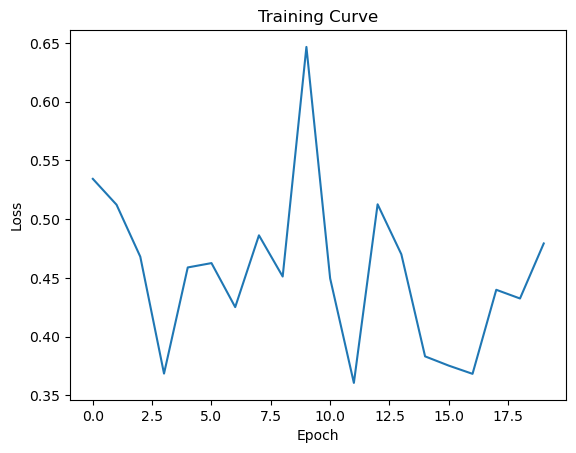

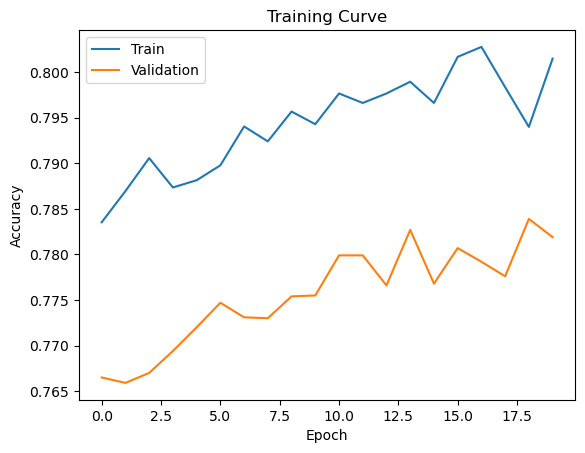

0.7832

In [38]:
class ReviewLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ReviewLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model_lstm = ReviewLSTM(100, 100, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
get_accuracy(model, test_loader)

On-The-Fly embedding

torch.Size([10, 196])
Epoch 1; Loss 0.704493; Train Acc 0.524058; Val Acc 0.525900
Epoch 2; Loss 0.719488; Train Acc 0.536260; Val Acc 0.536100
Epoch 3; Loss 0.637507; Train Acc 0.547768; Val Acc 0.545500
Epoch 4; Loss 0.699566; Train Acc 0.554067; Val Acc 0.548600
Epoch 5; Loss 0.668736; Train Acc 0.560665; Val Acc 0.552100
Epoch 6; Loss 0.687042; Train Acc 0.566419; Val Acc 0.555900
Epoch 7; Loss 0.684301; Train Acc 0.569048; Val Acc 0.558000
Epoch 8; Loss 0.647200; Train Acc 0.579960; Val Acc 0.560300
Epoch 9; Loss 0.659609; Train Acc 0.583234; Val Acc 0.562100
Epoch 10; Loss 0.674945; Train Acc 0.587302; Val Acc 0.562800
Epoch 11; Loss 0.698410; Train Acc 0.590377; Val Acc 0.565300
Epoch 12; Loss 0.655824; Train Acc 0.593948; Val Acc 0.568800
Epoch 13; Loss 0.689909; Train Acc 0.596280; Val Acc 0.570900
Epoch 14; Loss 0.687731; Train Acc 0.599206; Val Acc 0.575000
Epoch 15; Loss 0.640068; Train Acc 0.602480; Val Acc 0.576900
Epoch 16; Loss 0.621486; Train Acc 0.604464; Val Acc 0.57

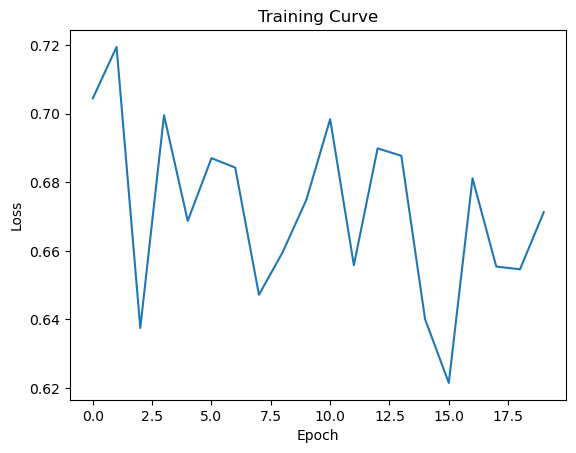

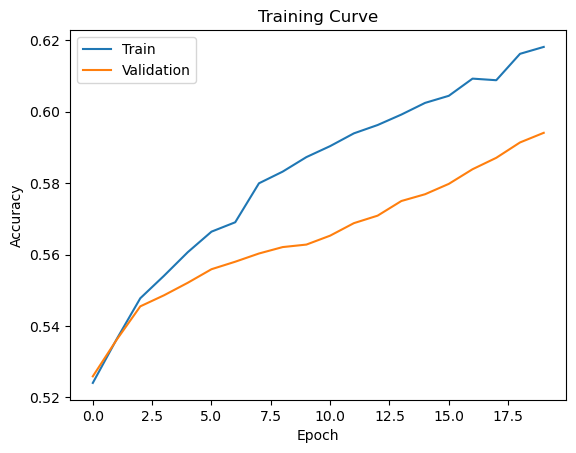

Test Accuracy:  0.606


In [44]:
class reviewRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
        super(reviewRNN, self).__init__()
        # Initialize an embedding layer without pre-trained weights
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Ensure indices are within the embedding layer's range
        x = torch.clamp(x, min=0, max=self.emb.num_embeddings - 1)
        x = self.emb(x)  # Convert word indices to embeddings
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # Initial hidden state
        out, _ = self.rnn(x, h0)  # RNN forward pass
        out = self.fc(out[:, -1, :])  # Output layer
        return out

# Example usage
vocab_size = 10000  # Define your vocab size
embed_dim = 100
model = reviewRNN(vocab_size, embed_dim, hidden_size=100, num_classes=2)

# Pad sequences for batching
review_padded = pad_sequence([review for review, label in train[:10]], batch_first=True)
print(review_padded.shape)

# Custom Batch Loader
class ReviewBatcher:
    def __init__(self, reviews, batch_size=32, drop_last=False):
        self.reviews_by_length = {}
        for words, label in reviews:
            wlen = words.shape[0]
            if wlen not in self.reviews_by_length:
                self.reviews_by_length[wlen] = []
            self.reviews_by_length[wlen].append((words, label))

        self.loaders = {wlen: torch.utils.data.DataLoader(reviews, batch_size=batch_size, shuffle=True, drop_last=drop_last)
                        for wlen, reviews in self.reviews_by_length.items()}
        
    def __iter__(self):
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for reviews, labels in data_loader:
        output = model(reviews)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

# Initialize Data Loaders
test_loader = ReviewBatcher(test, batch_size=64, drop_last=False)
train_loader = ReviewBatcher(train, batch_size=64, drop_last=True)
valid_loader = ReviewBatcher(valid, batch_size=64, drop_last=False)

def train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for reviews, labels in train_loader:
            optimizer.zero_grad()
            pred = model(reviews)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    
    # Plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

# Train the model with on-the-fly embeddings
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-5)

# Evaluate accuracy on test set
print("Test Accuracy: ", get_accuracy(model, test_loader))


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Using device: cuda
torch.Size([10, 196])
Epoch 1; Loss 0.690995; Train Acc 0.534524; Val Acc 0.530500
Epoch 2; Loss 0.671399; Train Acc 0.543204; Val Acc 0.537000
Epoch 3; Loss 0.673661; Train Acc 0.553571; Val Acc 0.546300
Epoch 4; Loss 0.689574; Train Acc 0.565030; Val Acc 0.553100
Epoch 5; Loss 0.671818; Train Acc 0.572371; Val Acc 0.559700
Epoch 6; Loss 0.674267; Train Acc 0.582391; Val Acc 0.564500
Epoch 7; Loss 0.683584; Train Acc 0.589236; Val Acc 0.568600
Epoch 8; Loss 0.687075; Train Acc 0.593800; Val Acc 0.573300
Epoch 9; Loss 0.667394; Train Acc 0.599107; Val Acc 0.580800
Epoch 10; Loss 0.655159; Train Acc 0.604712; Val Acc 0.585100
Epoch 11; Loss 0.666821; Train Acc 0.611607; Val Acc 0.590200
Epoch 12; Loss 0.707799; Train Acc 0.618204; Val Acc 0.596500
Epoch 13; Loss 0.684571; Train Acc 0.624752; Val Acc 0.599700
Epoch 14; Loss 0.641060; Train Acc 0.628175; Val Acc 0.607500
Epoch 15; Loss 0.599428; Train Acc 0.642014; Val Acc 0.619600
Epoch 16; Loss 0.655360; Train Acc 0.6

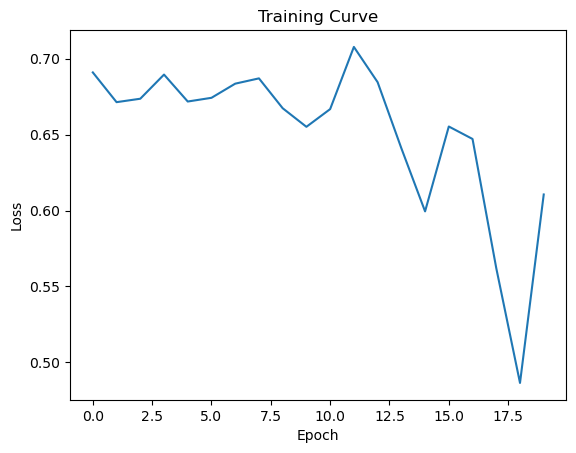

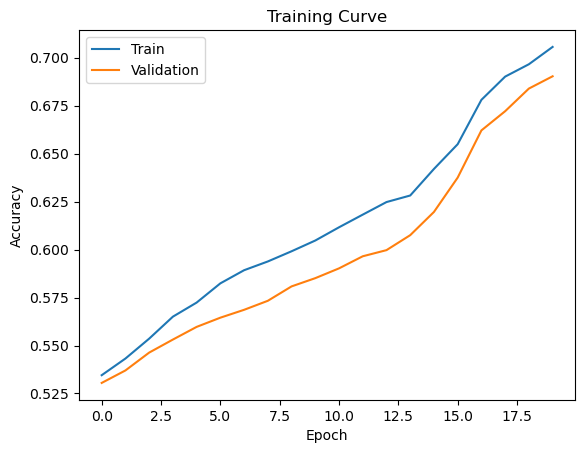

Test Accuracy:  0.6976


In [46]:
class reviewLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
        super(reviewLSTM, self).__init__()
        # Initialize an embedding layer without pre-trained weights
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)  # Replace RNN with LSTM
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Ensure indices are within the embedding layer's range
        x = torch.clamp(x, min=0, max=self.emb.num_embeddings - 1)
        x = self.emb(x)  # Convert word indices to embeddings
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM forward pass
        out = self.fc(out[:, -1, :])  # Output layer
        return out

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Example usage
vocab_size = 10000  # Define your vocab size
embed_dim = 100
model = reviewLSTM(vocab_size, embed_dim, hidden_size=100, num_classes=2).to(device)  # Move model to device

# Pad sequences for batching
review_padded = pad_sequence([review for review, label in train[:10]], batch_first=True).to(device)  # Ensure data is on the GPU
print(review_padded.shape)

# Custom Batch Loader
class ReviewBatcher:
    def __init__(self, reviews, batch_size=32, drop_last=False):
        self.reviews_by_length = {}
        for words, label in reviews:
            wlen = words.shape[0]
            if wlen not in self.reviews_by_length:
                self.reviews_by_length[wlen] = []
            self.reviews_by_length[wlen].append((words, label))

        self.loaders = {wlen: torch.utils.data.DataLoader(reviews, batch_size=batch_size, shuffle=True, drop_last=drop_last)
                        for wlen, reviews in self.reviews_by_length.items()}
        
    def __iter__(self):
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for reviews, labels in data_loader:
        reviews, labels = reviews.to(device), labels.to(device)  # Ensure data is on the GPU
        output = model(reviews)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

# Initialize Data Loaders
test_loader = ReviewBatcher(test, batch_size=64, drop_last=False)
train_loader = ReviewBatcher(train, batch_size=64, drop_last=True)
valid_loader = ReviewBatcher(valid, batch_size=64, drop_last=False)

def train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for reviews, labels in train_loader:
            reviews, labels = reviews.to(device), labels.to(device)  # Ensure data is on the GPU
            optimizer.zero_grad()
            pred = model(reviews)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    
    # Plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

# Train the model with on-the-fly embeddings
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-5)

# Evaluate accuracy on test set
print("Test Accuracy: ", get_accuracy(model, test_loader))
